In [1]:
# Import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns

In [2]:
# Import data
df = pd.read_csv(Path('../resources/regressiondata_2019.csv'))
df.head()

,Unnamed: 0,zpid,latestPrice,numOfBathrooms,livingAreaSqFt,numOfBedrooms,avgSchoolRating,numOfStories,MedianStudentsPerTeacher,numOfHighSchools,longitude,numOfPrimarySchools,zipcode,propertyTaxRate,latest_saledate,latest_salemonth,latest_saleyear
0,0,111373431,305000.0,3.0,2601.0,4,2.666667,2,14,1,-97.663078,1,78660,1.98,2019-09-02,9,2019
1,2,2084491383,256125.0,2.0,1478.0,3,3.000000,1,14,1,-97.639771,0,78660,1.98,2019-07-31,7,2019
2,8,60134833,225000.0,2.0,1870.0,3,4.000000,2,14,1,-97.657959,1,78660,1.98,2019-09-19,9,2019
3,11,241930967,250000.0,3.0,2281.0,3,3.000000,2,14,1,-97.633354,1,78617,1.98,2019-04-12,4,2019
4,16,70341946,212000.0,2.0,1752.0,4,3.333333,1,14,1,-97.616470,1,78617,1.98,2019-02-27,2,2019


In [3]:
df.columns

Index(['Unnamed: 0', 'zpid', 'latestPrice', 'numOfBathrooms', 'livingAreaSqFt',
       'numOfBedrooms', 'avgSchoolRating', 'numOfStories',
       'MedianStudentsPerTeacher', 'numOfHighSchools', 'longitude',
       'numOfPrimarySchools', 'zipcode', 'propertyTaxRate', 'latest_saledate',
       'latest_salemonth', 'latest_saleyear'],
      dtype='object')

In [4]:
# Save 'zpid'
id_df = df['zpid']

# Drop 'zpid' column
df.drop(["zpid","latest_saledate","Unnamed: 0",'latest_salemonth','latest_saleyear'], axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nData size: {} ".format(df.shape)) 


Data size: (5276, 12) 


In [5]:
# Create features and target
y = df["latestPrice"]
X = df.drop(columns=['latestPrice'])

In [6]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape

(3957, 11)

In [7]:
# Create DMatrices

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# "Learn" the mean from the training data
mean_train = np.mean(y_train)

# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 230520.15


In [9]:
# Create parameters dictionary
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [10]:
params['eval_metric'] = "mae"

num_boost_round = 999

In [11]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-mae:355183
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:255969
[2]	Test-mae:193712
[3]	Test-mae:155710
[4]	Test-mae:134099
[5]	Test-mae:123685
[6]	Test-mae:117829
[7]	Test-mae:116140
[8]	Test-mae:116067
[9]	Test-mae:116613
[10]	Test-mae:116661
[11]	Test-mae:116225
[12]	Test-mae:115787
[13]	Test-mae:114849
[14]	Test-mae:114753
[15]	Test-mae:114623
[16]	Test-mae:114390
[17]	Test-mae:114596
[18]	Test-mae:114222
[19]	Test-mae:114463
[20]	Test-mae:114358
[21]	Test-mae:114606
[22]	Test-mae:114472
[23]	Test-mae:114428
[24]	Test-mae:113890
[25]	Test-mae:113935
[26]	Test-mae:113482
[27]	Test-mae:113746
[28]	Test-mae:113512
[29]	Test-mae:113544
[30]	Test-mae:113534
[31]	Test-mae:113455
[32]	Test-mae:113531
[33]	Test-mae:113094
[34]	Test-mae:113209
[35]	Test-mae:112847
[36]	Test-mae:113011
[37]	Test-mae:112581
[38]	Test-mae:112530
[39]	Test-mae:112403
[40]	Test-mae:112040
[41]	Test-mae:111828
[42]	Test-mae:111634
[43]	Test-mae:111684
[44]	Test-mae:111664
[45]	Test

In [12]:
# Get cross validation score with current params
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,349904.493750,1352.490653,351557.375000,6041.761097
1,249609.100000,1112.239742,255141.056250,6530.388691
2,183295.021875,861.730149,193410.615625,6291.808585
3,141354.550000,779.946089,156740.396875,6586.778567
4,116383.526562,489.089768,135612.279688,7405.158304
5,102466.806250,757.978384,124068.431250,7482.122920
6,94655.337500,1294.125278,119023.298437,8057.788117
7,89315.709375,2084.102947,115547.667187,7401.999525
8,86186.484375,2230.856694,114178.984375,7502.161008
9,83810.520313,2320.170109,112991.743750,7574.862187


In [13]:
cv_results['test-mae-mean'].min()

107786.7046876

In [14]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,12)
    for min_child_weight in range(1,10)
]

In [15]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=4, min_child_weight=1
	MAE 107732.2656248 for 62 rounds
CV with max_depth=4, min_child_weight=2
	MAE 109489.35625 for 89 rounds
CV with max_depth=4, min_child_weight=3
	MAE 110142.021875 for 98 rounds
CV with max_depth=4, min_child_weight=4
	MAE 111490.421875 for 86 rounds
CV with max_depth=4, min_child_weight=5
	MAE 110884.0843748 for 73 rounds
CV with max_depth=4, min_child_weight=6
	MAE 110824.8343748 for 88 rounds
CV with max_depth=4, min_child_weight=7
	MAE 113628.1703124 for 101 rounds
CV with max_depth=4, min_child_weight=8
	MAE 113207.2875 for 86 rounds
CV with max_depth=4, min_child_weight=9
	MAE 110969.8609374 for 150 rounds
CV with max_depth=5, min_child_weight=1
	MAE 109858.85 for 39 rounds
CV with max_depth=5, min_child_weight=2
	MAE 109739.7125002 for 42 rounds
CV with max_depth=5, min_child_weight=3
	MAE 115732.5625 for 13 rounds
CV with max_depth=5, min_child_weight=4
	MAE 112389.634375 for 75 rounds
CV with max_depth=5, min_child_weight=5
	MAE 113479.

In [32]:
# Update parameters with best found parameters
params['max_depth'] = 11
params['min_child_weight'] = 9

In [17]:
# Tuning 'subsample' and 'colsample_bytree' parameters
# Create list of possible params
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [18]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 107437.9984374 for 25 rounds
CV with subsample=1.0, colsample=0.9
	MAE 106300.240625 for 30 rounds
CV with subsample=1.0, colsample=0.8
	MAE 107310.415625 for 18 rounds
CV with subsample=1.0, colsample=0.7
	MAE 106698.00625 for 28 rounds
CV with subsample=0.9, colsample=1.0
	MAE 111046.9984376 for 41 rounds
CV with subsample=0.9, colsample=0.9
	MAE 110983.86875 for 35 rounds
CV with subsample=0.9, colsample=0.8
	MAE 111221.3359376 for 36 rounds
CV with subsample=0.9, colsample=0.7
	MAE 110036.8125002 for 44 rounds
CV with subsample=0.8, colsample=1.0
	MAE 108810.9640626 for 11 rounds
CV with subsample=0.8, colsample=0.9
	MAE 110129.3640626 for 17 rounds
CV with subsample=0.8, colsample=0.8
	MAE 108787.1265626 for 31 rounds
CV with subsample=0.8, colsample=0.7
	MAE 109474.8171872 for 12 rounds
CV with subsample=0.7, colsample=1.0
	MAE 109532.1703126 for 13 rounds
CV with subsample=0.7, colsample=0.9
	MAE 111111.1046874 for 12 rounds
CV with subs

In [31]:
# Update params dictionary
params['subsample'] = 1.0
params['colsample_bytree'] = 0.9

In [20]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 110983.8718748 for 35 rounds

CV with eta=0.2
	MAE 109166.3140626 for 38 rounds

CV with eta=0.1
	MAE 106740.3484376 for 115 rounds

CV with eta=0.05
	MAE 104608.39375 for 209 rounds

CV with eta=0.01
	MAE 104930.7703126 for 530 rounds

CV with eta=0.005
	MAE 104955.9859374 for 997 rounds

Best params: 0.05, MAE: 104608.39375


In [21]:
# Update parameters dictionary
params['eta'] = .05

In [33]:
params

{'max_depth': 11,
 'min_child_weight': 9,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 0.9,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [34]:
# Train the model with the tuned parameters and use test data
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:478821
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:455427
[2]	Test-mae:433335
[3]	Test-mae:412090
[4]	Test-mae:392114
[5]	Test-mae:373373
[6]	Test-mae:355365
[7]	Test-mae:338569
[8]	Test-mae:322464
[9]	Test-mae:307148
[10]	Test-mae:292692
[11]	Test-mae:278911
[12]	Test-mae:266056
[13]	Test-mae:254017
[14]	Test-mae:242774
[15]	Test-mae:232201
[16]	Test-mae:222369
[17]	Test-mae:213076
[18]	Test-mae:204382
[19]	Test-mae:196182
[20]	Test-mae:188542
[21]	Test-mae:181406
[22]	Test-mae:174621
[23]	Test-mae:168501
[24]	Test-mae:162766
[25]	Test-mae:157765
[26]	Test-mae:153093
[27]	Test-mae:148772
[28]	Test-mae:144742
[29]	Test-mae:141166
[30]	Test-mae:137639
[31]	Test-mae:134487
[32]	Test-mae:131582
[33]	Test-mae:128967
[34]	Test-mae:126718
[35]	Test-mae:124457
[36]	Test-mae:122400
[37]	Test-mae:120466
[38]	Test-mae:118537
[39]	Test-mae:117014
[40]	Test-mae:115257
[41]	Test-mae:113920
[42]	Test-mae:112708
[43]	Test-mae:111531
[44]	Test-mae:110614
[45]	Test

In [35]:
# Save model with best parameters
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:478821
[1]	Test-mae:455427
[2]	Test-mae:433335
[3]	Test-mae:412090
[4]	Test-mae:392114
[5]	Test-mae:373373
[6]	Test-mae:355365
[7]	Test-mae:338569
[8]	Test-mae:322464
[9]	Test-mae:307148
[10]	Test-mae:292692
[11]	Test-mae:278911
[12]	Test-mae:266056
[13]	Test-mae:254016
[14]	Test-mae:242774
[15]	Test-mae:232201
[16]	Test-mae:222369
[17]	Test-mae:213076
[18]	Test-mae:204382
[19]	Test-mae:196182
[20]	Test-mae:188542
[21]	Test-mae:181406
[22]	Test-mae:174621
[23]	Test-mae:168501
[24]	Test-mae:162766
[25]	Test-mae:157765
[26]	Test-mae:153093
[27]	Test-mae:148772
[28]	Test-mae:144742
[29]	Test-mae:141166
[30]	Test-mae:137639
[31]	Test-mae:134487
[32]	Test-mae:131582
[33]	Test-mae:128967
[34]	Test-mae:126718
[35]	Test-mae:124457
[36]	Test-mae:122400
[37]	Test-mae:120466
[38]	Test-mae:118537
[39]	Test-mae:117014
[40]	Test-mae:115257
[41]	Test-mae:113920
[42]	Test-mae:112708
[43]	Test-mae:111531
[44]	Test-mae:110614
[45]	Test-mae:109556
[46]	Test-mae:108696
[47]	Test-mae:107866
[4

In [36]:
# Create prediction
y_pred = best_model.predict(dtest)

In [37]:
# Save model
best_model.save_model("xgboost_optimal_2019.model")

In [38]:
# Calculate R squared and Adjusted R Square
import statsmodels.api as sm
result = sm.OLS(y_pred, y_test).fit()
print(result.rsquared, result.rsquared_adj)

0.8419476712848039 0.8418277529777362


In [39]:
# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import math
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_squared_log_error(y_test, y_pred))

70332706537.58963
265203.1420205832
0.10514559483725236


In [40]:
# Calculate Mean Absolute Error(MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

101860.87013125473


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

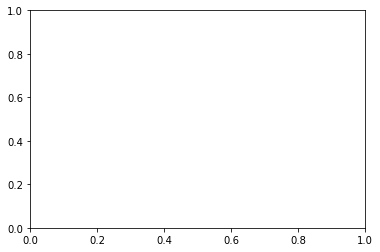

In [30]:
import matplotlib.pyplot as plt

# extra step to allow graphviz to be found 
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/danny/.conda/envs/mlenv/lib/site-packages/graphviz'

xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
# # Code to load model for other datasets:
# loaded_model = xgb.Booster()
# loaded_model.load_model("my_model.model")
# # And use it for predictions.
# loaded_model.predict(dtest)